In [208]:
# Importing Standard Libraries
import pandas as pd
import numpy as np
from csv import reader

# Sklearn Libraries
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_mutual_info_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Importing mlxtend Libraries
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [209]:
# Importing the Data Set
# df =  pd.read_csv("bank.csv")
df =  pd.read_csv("bank-full.csv")
df.head()

# Establishing copies for running through the different scrubs
df_a = df.copy()
df_b = df.copy()


# Part 2
Changing all non-numeric into category data for PCA

In [210]:
df_b['job'] = df_b['job'].astype('category')
df_b['job'] = df_b['job'].cat.codes
df_b['marital'] = df_b['marital'].astype('category')
df_b['marital'] = df_b['marital'].cat.codes
df_b['education'] = df_b['education'].astype('category')
df_b['education'] = df_b['education'].cat.codes
df_b['default'] = df_b['default'].astype('category')
df_b['default'] = df_b['default'].cat.codes
df_b['contact'] = df_b['contact'].astype('category')
df_b['contact'] = df_b['contact'].cat.codes
df_b['month'] = df_b['month'].astype('category')
df_b['month'] = df_b['month'].cat.codes
df_b['poutcome'] = df_b['poutcome'].astype('category')
df_b['poutcome'] = df_b['poutcome'].cat.codes
df_b['housing'] = df_b['housing'].astype('category')
df_b['housing'] = df_b['housing'].cat.codes
df_b['loan'] = df_b['loan'].astype('category')
df_b['loan'] = df_b['loan'].cat.codes
df_b['y'] = df_b['y'].astype('category')
df_b['y'] = df_b['y'].cat.codes
df_b = df_b.drop('pdays',axis=1)
df_b['balance'] = (df_b['balance'] - df_b['balance'].min()) / ( df_b['balance'].max() - df_b['balance'].min())
print("Post Conversion of Data into numeric, dropping pdays, and normalizing balance:")
df_b.head(10)

Post Conversion of Data into numeric, dropping pdays, and normalizing balance:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,58,4,1,2,0,0.092259,1,0,2,5,8,261,1,0,3,0
1,44,9,2,1,0,0.073067,1,0,2,5,8,151,1,0,3,0
2,33,2,1,1,0,0.072822,1,1,2,5,8,76,1,0,3,0
3,47,1,1,3,0,0.086476,1,0,2,5,8,92,1,0,3,0
4,33,11,2,3,0,0.072812,0,0,2,5,8,198,1,0,3,0
5,35,4,1,2,0,0.074901,1,0,2,5,8,139,1,0,3,0
6,28,4,2,2,0,0.076862,1,1,2,5,8,217,1,0,3,0
7,42,2,0,2,1,0.072822,1,0,2,5,8,380,1,0,3,0
8,58,5,1,0,0,0.073902,1,0,2,5,8,50,1,0,3,0
9,43,9,2,1,0,0.078187,1,0,2,5,8,55,1,0,3,0


Exploratory Data Analysis

In [211]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45211 non-null  int64  
 1   job        45211 non-null  int8   
 2   marital    45211 non-null  int8   
 3   education  45211 non-null  int8   
 4   default    45211 non-null  int8   
 5   balance    45211 non-null  float64
 6   housing    45211 non-null  int8   
 7   loan       45211 non-null  int8   
 8   contact    45211 non-null  int8   
 9   day        45211 non-null  int64  
 10  month      45211 non-null  int8   
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  previous   45211 non-null  int64  
 14  poutcome   45211 non-null  int8   
 15  y          45211 non-null  int8   
dtypes: float64(1), int64(5), int8(10)
memory usage: 2.5 MB


In [212]:
df_b.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,4.339762,1.167725,1.224813,0.018027,0.085171,0.555838,0.160226,0.640242,15.806419,5.523014,258.163080,2.763841,0.580323,2.559974,0.116985
std,10.618762,3.272657,0.608230,0.747997,0.133049,0.027643,0.496878,0.366820,0.897951,8.322476,3.006911,257.527812,3.098021,2.303441,0.989059,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,0.073457,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,0.000000,3.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,0.076871,1.000000,0.000000,0.000000,16.000000,6.000000,180.000000,2.000000,0.000000,3.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,0.085768,1.000000,0.000000,2.000000,21.000000,8.000000,319.000000,3.000000,0.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,31.000000,11.000000,4918.000000,63.000000,275.000000,3.000000,1.000000


The Descriptions from the data right now show that the data is displaying a lot of different scales.
Namely the following
- Age
- previous
- Duration
- Month
- Day <br>

This Leads us to believe that we need to standardize the data to bring them into scale so that our
different models are not affected disproportionately

<AxesSubplot:>

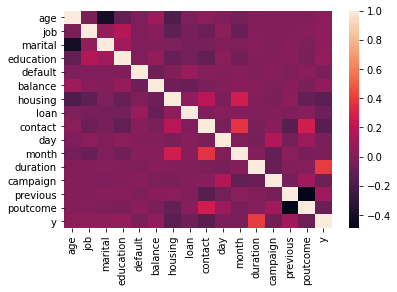

In [213]:
sns.heatmap(df_b.corr())

From the Correlation Map we can see that Y has a high correlation with marital status followed by education and housing.


Splitting the Data into X and Y

In [214]:
y = df_b["y"]
X = df_b.drop("y", axis=1)

Taking another look at the correlation of only the features

<AxesSubplot:>

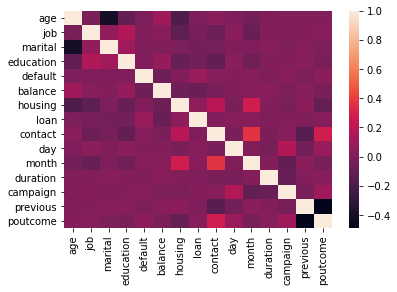

In [215]:
sns.heatmap(X.corr())

Setting the data up into training and testing splits

In [216]:
# Splitting the dataset into Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

Now I want to look at reducing the number of features and get rid of any correlation between the two

First I will want to scale the data

In [217]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print("Number of Features:{}".format(n_to_reach_95))
print("Total Variance Explained:{}".format(total_explained_variance[n_to_reach_95-1]))

Number of Features:14
Total Variance Explained:0.9695974883329092


In [218]:
pipe = Pipeline([('scalar', StandardScaler()),
                 ('pca', PCA(n_components=n_to_reach_95, random_state=0)),
                 ('dt', tree.DecisionTreeClassifier())])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('pca', PCA(n_components=14, random_state=0)),
                ('dt', DecisionTreeClassifier())])

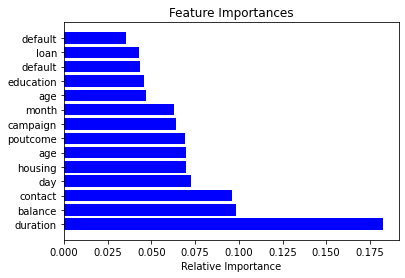

In [219]:
model = pipe.steps[1][1]
n_pcs = model.components_.shape[0]
initial_feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)

features, importances = zip(*zipped_feats)
top_features = features[:15]
top_importances = importances[:15]

plt.title("Feature Importances")
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel("Relative Importance")
plt.show()

The Function Below Gathers the Accuracies for the different amount of components for PCA

In [220]:
def gather_model_accuracies(class_type, name):
    """This function takes in Different Classifiers to gather accuracies"""
    accuracy = []
    for i in range(1,16):
        pipe = Pipeline([('scalar', StandardScaler()),
                         ('preprocessor', PCA(n_components=i, random_state=0)),
                         ('clf', class_type)])
        pipe.fit(X_train, y_train)
        y_prediction = pipe.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_prediction))
    accuracy = pd.DataFrame(accuracy, index=[i for i in range(1,16)], columns=[name])
    return accuracy

The Function Below Graphs the Accuracies Gathered from above

In [221]:
dtree_accuracy = gather_model_accuracies(tree.DecisionTreeClassifier(), "Decision Tree")
dtree_accuracy

,Decision Tree
1,0.802720
2,0.806922
3,0.817760
4,0.827933
5,0.839102
6,0.837443
7,0.848833
8,0.855358
9,0.848612
10,0.850050


In [222]:
gnb_accuracy = gather_model_accuracies(GaussianNB(), "Gaussian")
gnb_accuracy

,Gaussian
1,0.882451
2,0.882451
3,0.881345
4,0.882119
5,0.882672
6,0.883003
7,0.884773
8,0.884883
9,0.885879
10,0.885657


In [223]:
k_means_accuracy = gather_model_accuracies(KMeans(), "K-Means")
k_means_accuracy

,K-Means
1,0.168528
2,0.180139
3,0.121530
4,0.137565
5,0.156032
6,0.214531
7,0.158686
8,0.153268
9,0.017583
10,0.289506


Joining the Accuracies Into a Graph

In [224]:
joined_models = pd.concat([dtree_accuracy, gnb_accuracy], axis=1)
joined_models["index"] = joined_models.index

<AxesSubplot:xlabel='index', ylabel='value'>

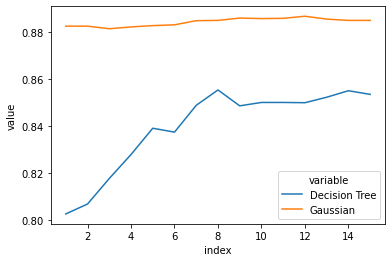

In [225]:
sns.lineplot(x = 'index', y= 'value', hue ="variable", data= pd.melt(joined_models, ['index']))